In [1]:
import numpy as np
import pandas as pd

import os
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
# Loads dataset & processes it:
# - fills NA data
# - processes categorical data so that categories from both train&test are known
def load_dataset(dataset, drop_columns=None):
    df_train = pd.read_csv("./2019-npfl104-shared/data/"+dataset+"/train.txt.gz", header=None)
    df_test = pd.read_csv("./2019-npfl104-shared/data/"+dataset+"/test.txt.gz", header=None)

    train_size = len(df_train)
    df_tog = df_train.append(df_test)

    # Convert to categorical
    for col in df_tog.columns[np.where(df_tog.dtypes == 'object')]:
        df_tog[col] = pd.Categorical(df_tog[col])

    # Drop too unique columns e.g. ids
    for col in df_tog.columns:
        idlike_col = []
        if df_tog[col].nunique() > 0.6 * len(df_tog):
            idlike_col.append(col)
    df_tog = df_tog.drop(idlike_col, axis=1)
        
    # Explicitely drop specified columns
    if drop_columns:
        df_tog = df_tog.drop(drop_columns, axis=1)

    df_train, df_test = df_tog[:train_size], df_tog[train_size:]
    
    df_train = df_train.fillna(df_train.mode().iloc[0])
    df_test = df_test.fillna(df_test.mode().iloc[0])
    
    return df_train, df_test

# Used to split dataframe to features & target (last column)
def get_X(df):
    return pd.get_dummies(df[df.columns[:-1]], dummy_na=True)
def get_Y(df):
    dfc = df[df.columns[-1]]
    return dfc.cat.codes if dfc.dtype.name == "category" else dfc


dftr, dfte = load_dataset("pamap-easy")


In [3]:
classifiers = [
    (SVC(kernel="linear", C=1, gamma='scale'), "SVC", "l"),
    (SVC(kernel="poly", C=1, gamma='scale'), "SVC", "p"),
    (SVC(kernel="rbf", C=1, gamma='scale'), "SVC", "p"),
]

In [4]:
for cls in classifiers:
    model, cls_name, cls_args = cls
        
    score = cross_val_score(model, get_X(dftr), get_Y(dftr), cv=5)  
    print(score)

[0.93932695 0.94103194 0.94810625 0.94609894 0.93868505]
[0.80373373 0.79041769 0.78873586 0.79891706 0.80004925]
[0.69638909 0.68304668 0.6957698  0.69628353 0.69884265]


In [20]:
parameters = {
    'kernel':['rbf'], 
    'C':[0.1, 1, 10, 100, 1000, 10000], 
    'gamma': [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
}

In [21]:
model = SVC(gamma='scale')
gs = GridSearchCV(model, parameters, cv=3, n_jobs=-2, return_train_score=True)

res = gs.fit(get_X(dftr), get_Y(dftr))

In [22]:
res
res.cv_results_

{'mean_fit_time': array([ 8.1831948 ,  7.58570321, 10.45382126, 17.07232118, 29.05416083,
        36.39228018,  5.73428305,  3.46336325,  6.67158588, 10.9614354 ,
        15.38433266, 22.37692491,  5.20551348,  2.29468012,  3.11168631,
         6.46348151, 10.53065093, 14.79397647, 11.74919033,  2.69229349,
         3.00405383,  5.03583519,  7.33620485, 11.00540471, 19.10666664,
        13.75279824,  4.45158744,  5.29679751,  7.11788615,  9.323934  ,
        40.18448432, 25.3921903 , 13.57369184,  5.42598979,  4.84777133,
         5.66169341]),
 'std_fit_time': array([0.24864752, 0.63336659, 0.31564829, 0.73190464, 0.45059132,
        2.13451585, 0.47302772, 0.9562492 , 0.46197722, 1.00044659,
        0.93612854, 1.40191652, 0.21193905, 0.94270383, 0.69532126,
        0.428814  , 0.46302973, 1.15910051, 1.36555307, 0.92711909,
        0.97997493, 0.05111538, 0.39349886, 0.15744236, 2.69314129,
        2.82915229, 1.13464157, 0.34320194, 0.48175084, 0.92093878,
        5.97717535, 3.884

In [33]:
# https://qiita.com/bmj0114/items/8009f282c99b77780563
heat_score = res.cv_results_['mean_test_score'].reshape(len(parameters['gamma']),len(parameters['C']))
heat_score

array([[0.82996409, 0.7682357 , 0.65018937, 0.5020904 , 0.2749004 ,
        0.10924204],
       [0.92622104, 0.86705032, 0.76636663, 0.65250111, 0.49972948,
        0.2749004 ],
       [0.95937239, 0.93915695, 0.86877183, 0.76479268, 0.63154788,
        0.49972948],
       [0.97678422, 0.96797993, 0.9431902 , 0.8520486 , 0.77084256,
        0.62318627],
       [0.97801387, 0.97707934, 0.97216074, 0.94087846, 0.84167036,
        0.7458069 ],
       [0.97811224, 0.97766957, 0.97648911, 0.96886528, 0.93669765,
        0.85185185]])

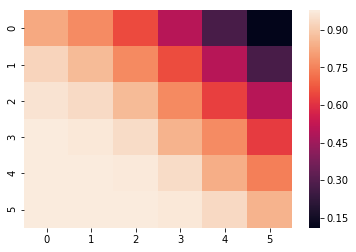

In [38]:
fig = sns.heatmap(heat_score)
fig.figure.savefig("heatmap.png")
fig

In [35]:
res.score(get_X(dfte), get_Y(dfte))


0.9760956175298805

In [36]:
res.best_params_ # res.cv_results_['params'][np.argmax(res.cv_results_['mean_test_score'])] alternatively 

{'C': 10000, 'gamma': 0.1, 'kernel': 'rbf'}